# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.942221,False,-0.481036
1,-2.689740,True,2.691270
2,0.418382,True,5.407442
3,0.767454,True,5.489635
4,-1.049987,False,-1.762481
...,...,...,...
995,1.845456,True,6.317095
996,0.430530,False,2.410149
997,-0.247464,True,4.819919
998,-0.167812,True,4.511350


<AxesSubplot: xlabel='v0'>

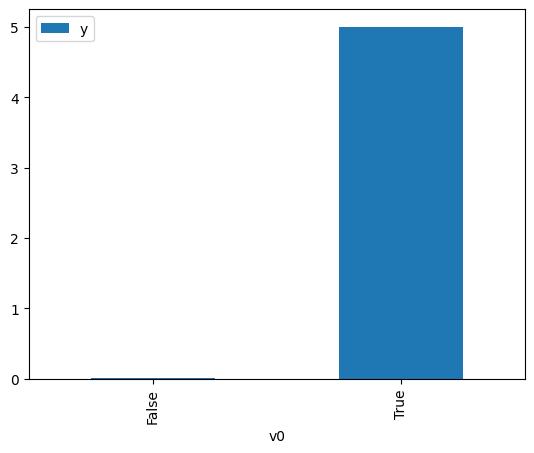

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

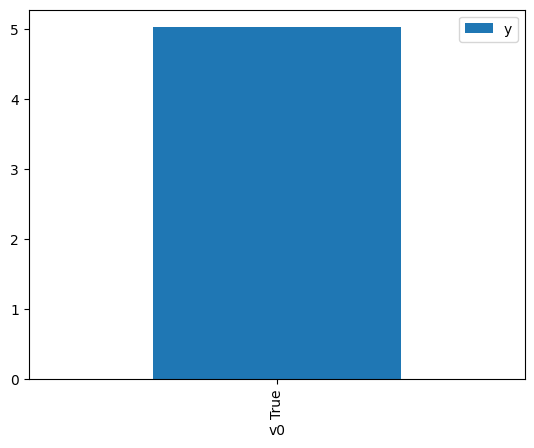

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.117572,False,-1.251556,0.485724,2.058782
1,0.909749,False,-0.279609,0.488743,2.046066
2,-1.587975,False,-0.298389,0.481405,2.077253
3,-1.654083,False,-0.816746,0.481211,2.078091
4,-0.614750,False,-1.593530,0.484263,2.064992
...,...,...,...,...,...
995,-0.775392,False,-0.514784,0.483791,2.067006
996,-0.166905,False,-0.312468,0.485579,2.059397
997,-1.700841,False,-2.471519,0.481074,2.078684
998,-1.446262,False,0.421636,0.481821,2.075459


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.552626,True,4.780679,0.512307,1.951956
1,-0.694602,True,3.826533,0.515971,1.938093
2,-1.009518,True,4.073917,0.516896,1.934624
3,-0.482241,True,4.892678,0.515347,1.940439
4,-1.212939,True,2.311308,0.517494,1.932391
...,...,...,...,...,...
995,2.087655,True,7.468169,0.507795,1.969299
996,-0.928226,True,4.774114,0.516657,1.935518
997,1.990984,True,5.372982,0.508079,1.968198
998,0.351192,True,4.989443,0.512899,1.949703


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              6765.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                        0.00
Time:                        17:20:04   Log-Likelihood:                         -1407.2
No. Observations:                1000   AIC:                                      2818.
Df Residuals:                     998   BIC:                                      2828.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7044      0.032     22.338      0.000       0.643       0.766
x2             5.0023      0.044    114.604      0.000       4.917       5.088
==============================================================================
Omnibus:                        0.568   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.522
Skew:                          -0.055   Prob(JB):                        0.770
Kurtosis:                       3.018   Cond. No.                         1.39
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""